In [2]:
import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv(r"E:\Python\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\Notebooks\full_battery_data.csv")

# Normalize SOC to 0–1
if df['SOC'].max() > 1:
    df['SOC'] = df['SOC'] / 100

# Sort values (important for time series)
df = df.sort_values(by=['TemperatureLabel', 'DriveCycle', 'Time']).reset_index(drop=True)


In [3]:
# Group the data
data_groups = {
    (temp, cycle): group.reset_index(drop=True)
    for (temp, cycle), group in df.groupby(['TemperatureLabel', 'DriveCycle'])
}


In [ ]:
stress_metrics = []

for (temp, cycle), group in data_groups.items():
    time = group['Time'].values
    voltage = group['Voltage'].values
    current = group['Current'].values
    temperature = group['Temperature'].values
    soc = group['SOC'].values

    # Time difference dt (assuming evenly spaced)
    dt = np.mean(np.diff(time))  # e.g., 0.1 for 10Hz

    # Metrics
    peak_current = np.max(np.abs(current))
    rms_current = np.sqrt(np.mean(current**2))
    delta_temp = temperature[-1] - temperature[0]
    power = voltage * current
    energy_throughput = np.sum(np.abs(power)) * dt  # ∫|V·I|dt
    regen_events = np.sum((current[:-1] * current[1:] < 0).astype(int))
    duration = time[-1] - time[0]
    dod = soc[0] - soc[-1]  # Depth of Discharge

    stress_metrics.append({
        'TemperatureLabel': temp,
        'DriveCycle': cycle,
        'PeakCurrent': peak_current,
        'RMSCurrent': rms_current,
        'DeltaTemperature': delta_temp,
        'EnergyThroughput': energy_throughput,
        'RegenEvents': regen_events,
        'CycleDuration': duration,
        'DOD': dod
    })


In [5]:
stress_df = pd.DataFrame(stress_metrics)

# Save to CSV
stress_df.to_csv(r"E:\Python\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\Dataset\Outcome\stress_metrics_summary.csv", index=False)

# Display
print(stress_df.head())


   TemperatureLabel DriveCycle  PeakCurrent  RMSCurrent  DeltaTemperature  \
0                 5       BCDC     9.934162    1.819009          2.954390   
1                 5      CSHVC    10.200031    2.232025          2.122800   
2                 5     FTP-72    10.200036    1.692528          0.987625   
3                 5     FTP-75    10.148452    1.853474          1.287710   
4                 5      HHDDT     9.449275    2.537181          7.190364   

   EnergyThroughput  RegenEvents  CycleDuration       DOD  
0      77125.902876         1896        18673.8  0.883794  
1      70884.384390         2236        14874.7  0.851008  
2      69778.933212         2034        18038.0  0.848653  
3      70315.368877         1780        16582.1  0.871401  
4      55973.703125          275         9547.0  0.859549  


C:\Users\rrayh\AppData\Local\Temp\ipykernel_18280\1318266634.py:13: UserWarning: Glyph 128267 (\N{BATTERY}) missing from current font.
  plt.tight_layout()
e:\Python\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128267 (\N{BATTERY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


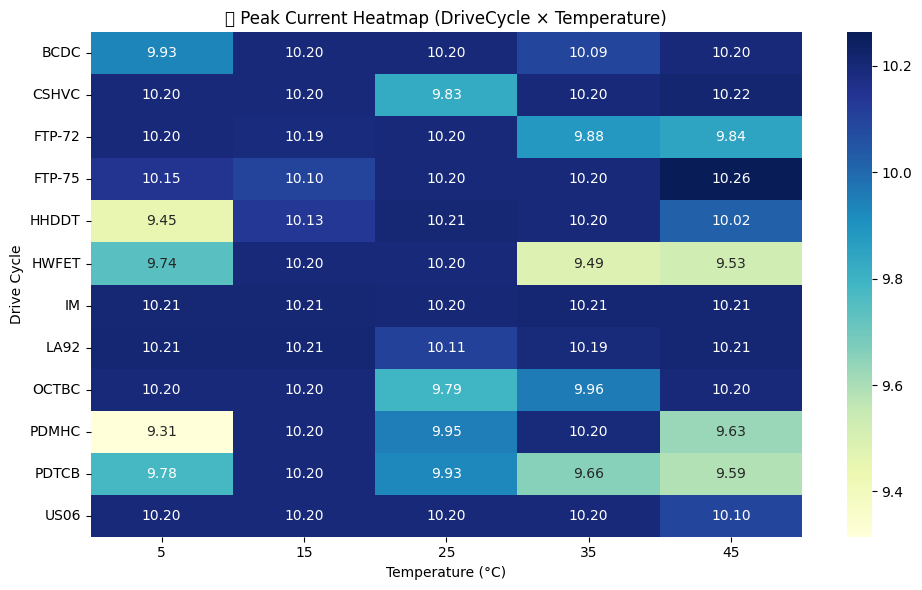

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Pivot for heatmap
pivot_df = stress_df.pivot(index='DriveCycle', columns='TemperatureLabel', values='PeakCurrent')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("🔋 Peak Current Heatmap (DriveCycle × Temperature)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Drive Cycle")
plt.tight_layout()
plt.show()


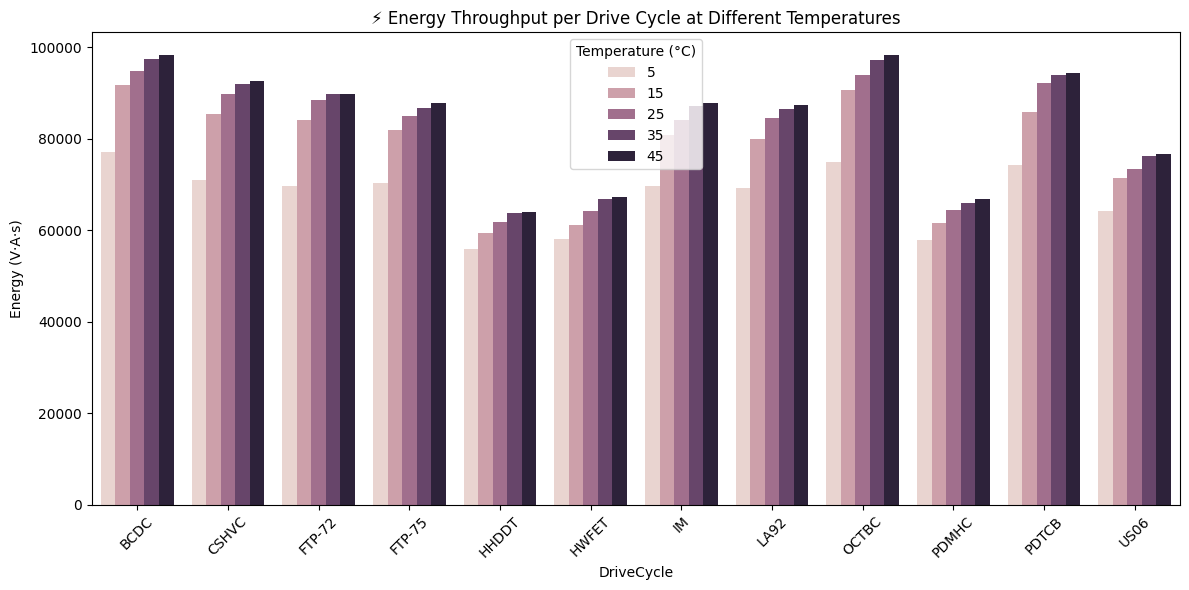

In [7]:
plt.figure(figsize=(12, 6))
sns.barplot(data=stress_df, x="DriveCycle", y="EnergyThroughput", hue="TemperatureLabel")
plt.title("⚡ Energy Throughput per Drive Cycle at Different Temperatures")
plt.ylabel("Energy (V·A·s)")
plt.xticks(rotation=45)
plt.legend(title="Temperature (°C)")
plt.tight_layout()
plt.show()


C:\Users\rrayh\AppData\Local\Temp\ipykernel_18280\673949635.py:11: UserWarning: Glyph 128267 (\N{BATTERY}) missing from current font.
  plt.tight_layout()
e:\Python\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128267 (\N{BATTERY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


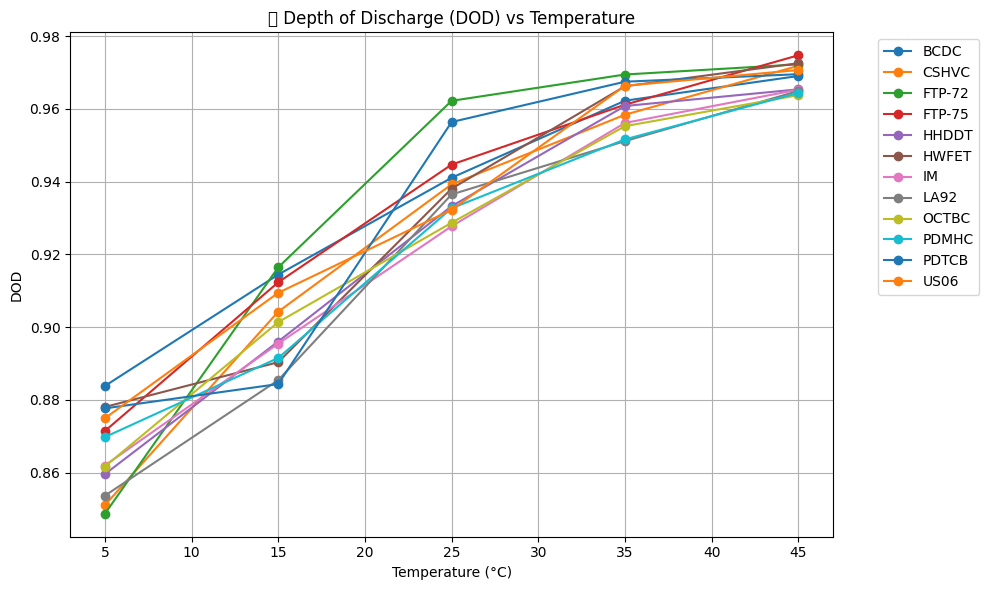

In [8]:
plt.figure(figsize=(10, 6))
for cycle in stress_df['DriveCycle'].unique():
    subset = stress_df[stress_df['DriveCycle'] == cycle]
    plt.plot(subset['TemperatureLabel'], subset['DOD'], marker='o', label=cycle)

plt.title("🔋 Depth of Discharge (DOD) vs Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("DOD")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\rrayh\AppData\Local\Temp\ipykernel_18280\3894566086.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
e:\Python\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


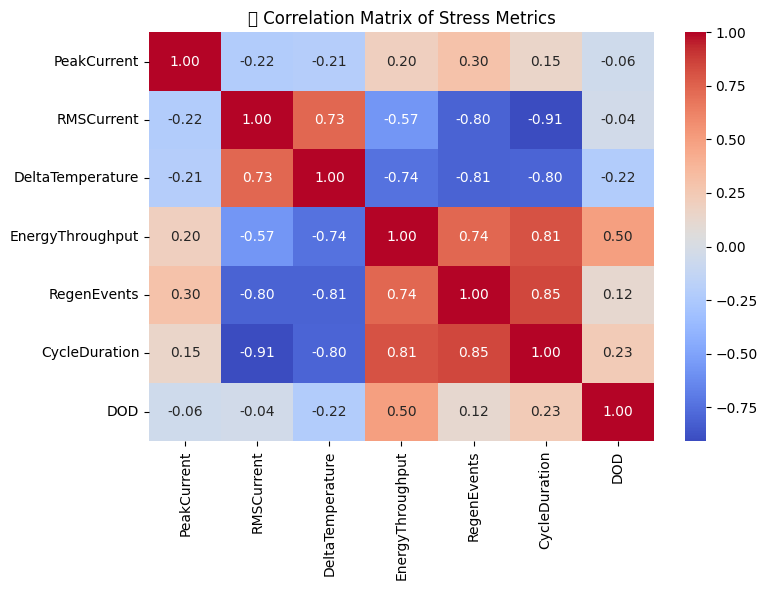

In [9]:
# Compute correlations between stress metrics
corr_df = stress_df.drop(columns=['TemperatureLabel', 'DriveCycle']).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("📈 Correlation Matrix of Stress Metrics")
plt.tight_layout()
plt.show()


C:\Users\rrayh\AppData\Local\Temp\ipykernel_18280\1472540101.py:6: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from current font.
  plt.tight_layout()
e:\Python\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


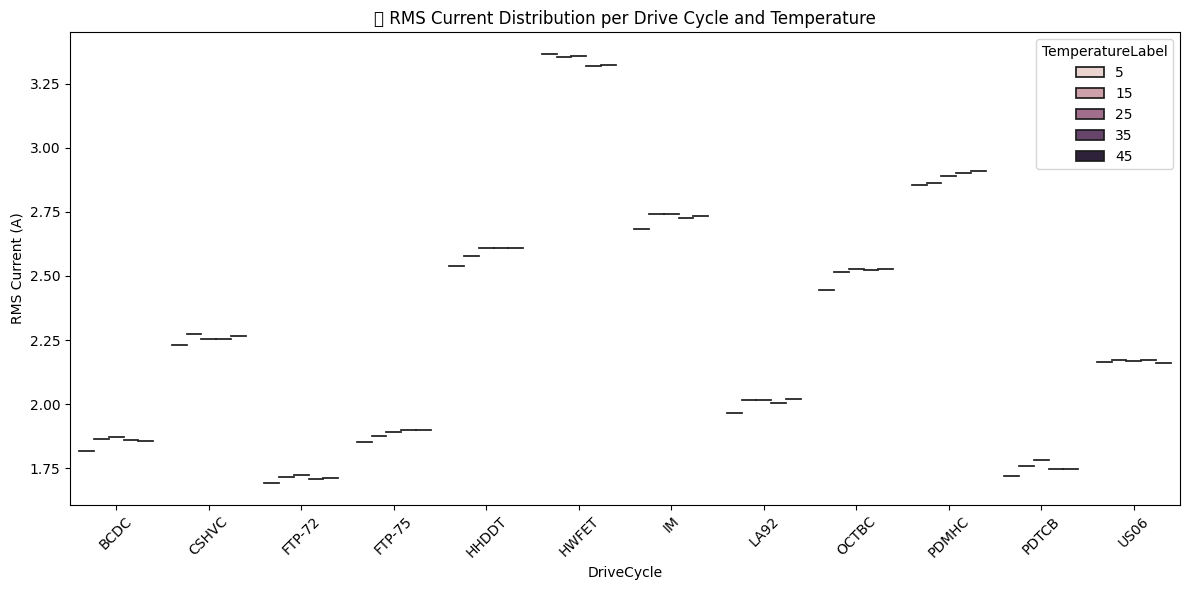

In [10]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=stress_df, x="DriveCycle", y="RMSCurrent", hue="TemperatureLabel", split=True)
plt.title("🎻 RMS Current Distribution per Drive Cycle and Temperature")
plt.xticks(rotation=45)
plt.ylabel("RMS Current (A)")
plt.tight_layout()
plt.show()


e:\Python\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


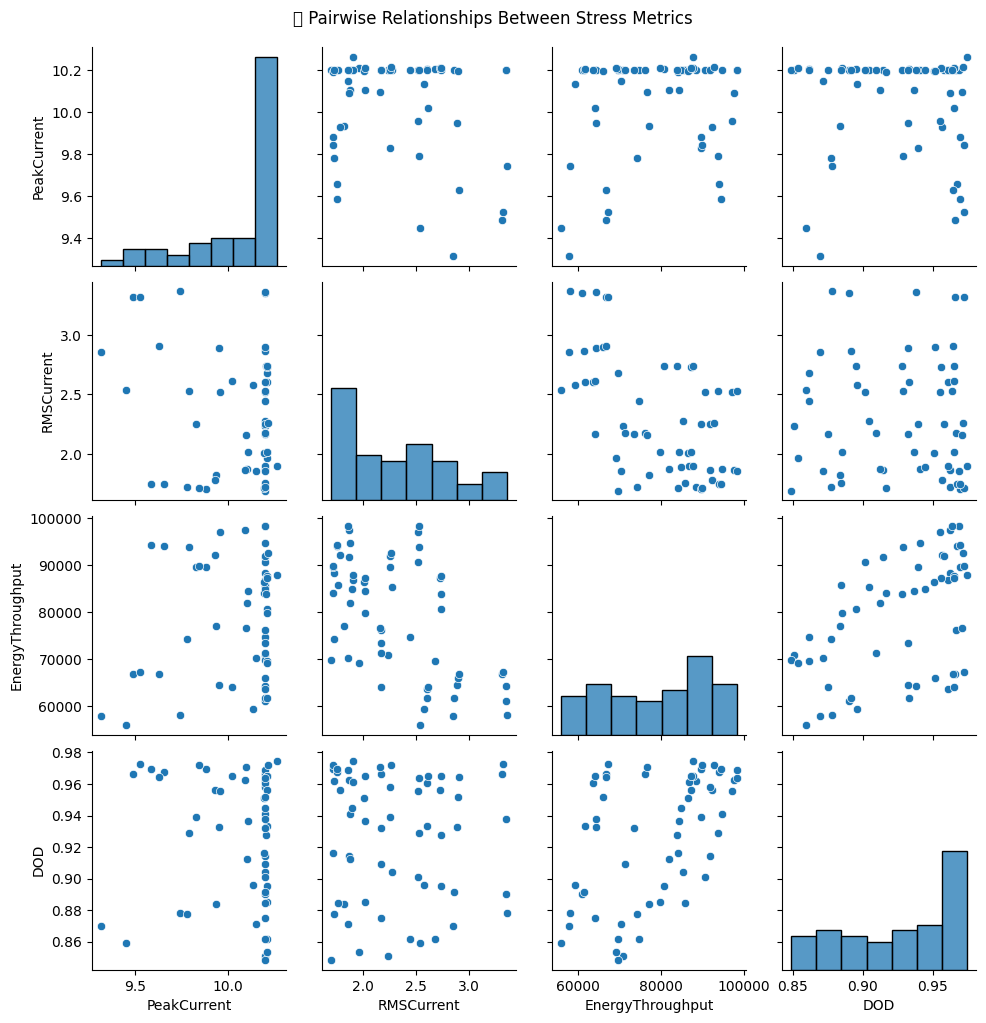

In [11]:
selected_cols = ["PeakCurrent", "RMSCurrent", "EnergyThroughput", "DOD"]
sns.pairplot(stress_df[selected_cols])
plt.suptitle("📉 Pairwise Relationships Between Stress Metrics", y=1.02)
plt.show()


C:\Users\rrayh\AppData\Local\Temp\ipykernel_18280\604979344.py:18: UserWarning: Glyph 129767 (\U0001fae7) missing from current font.
  plt.tight_layout()
e:\Python\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129767 (\U0001fae7) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


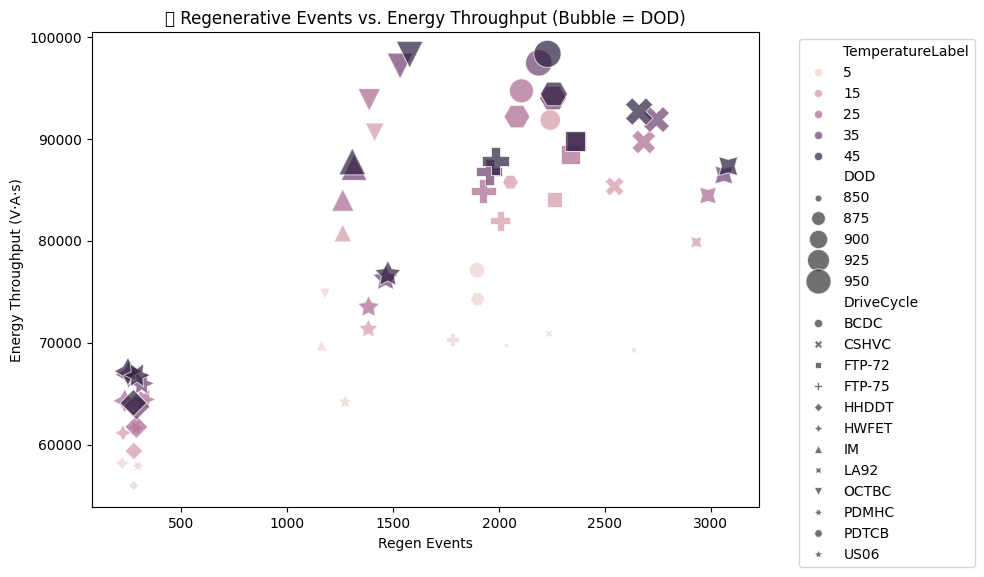

In [12]:
plt.figure(figsize=(10, 6))
bubble_sizes = stress_df["DOD"] * 1000  # scale up for better visibility

sns.scatterplot(
    data=stress_df,
    x="RegenEvents",
    y="EnergyThroughput",
    size=bubble_sizes,
    hue="TemperatureLabel",
    style="DriveCycle",
    sizes=(20, 400),
    alpha=0.7
)
plt.title("🫧 Regenerative Events vs. Energy Throughput (Bubble = DOD)")
plt.xlabel("Regen Events")
plt.ylabel("Energy Throughput (V·A·s)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



C:\Users\rrayh\AppData\Local\Temp\ipykernel_18280\1313784000.py:31: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from current font.
  plt.tight_layout()
e:\Python\Research\NextEnergy\XAI-ML-SOC-Prediction-TimeSeries\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


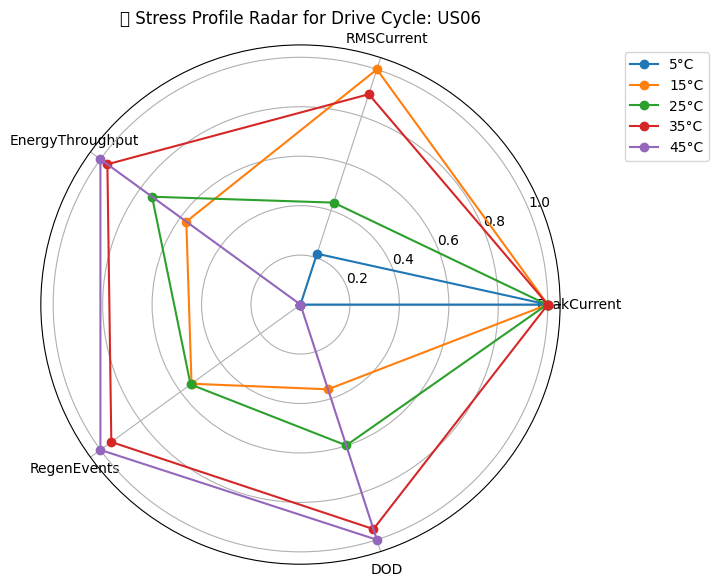

In [13]:
import numpy as np

def plot_radar_for_drive_cycle(cycle_name):
    from math import pi

    df_cycle = stress_df[stress_df['DriveCycle'] == cycle_name].sort_values("TemperatureLabel")

    # Select features
    features = ["PeakCurrent", "RMSCurrent", "EnergyThroughput", "RegenEvents", "DOD"]
    num_vars = len(features)

    # Normalize each metric (0–1) for fair radar plot
    norm_df = df_cycle.copy()
    for f in features:
        f_min, f_max = norm_df[f].min(), norm_df[f].max()
        norm_df[f] = (norm_df[f] - f_min) / (f_max - f_min + 1e-6)

    # Start radar plot
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # loop back to start

    plt.figure(figsize=(8, 6))
    for _, row in norm_df.iterrows():
        values = row[features].tolist()
        values += values[:1]
        plt.polar(angles, values, label=f"{int(row['TemperatureLabel'])}°C", marker='o')

    plt.xticks(angles[:-1], features)
    plt.title(f"🕸️ Stress Profile Radar for Drive Cycle: {cycle_name}")
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.tight_layout()
    plt.show()

# Call the function for a drive cycle
plot_radar_for_drive_cycle("US06")
